In [4]:
# For data manipulation
import pandas as pd
import numpy as np

# For data visualization
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# For NLP(text cleaning)
import nltk
import re
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# For NLP(feature extraction)
from sklearn.feature_extraction.text import TfidfVectorizer

# For dimension reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

# For clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN, AgglomerativeClustering

# For file handeling operations
import os
from glob import glob
from tqdm import tqdm

# To supress warnings
import warnings
warnings.filterwarnings("ignore")

* Change the plotting background to dark

In [5]:
sns.set_style("dark")

## Read the data

In [9]:
# Absolute path of all the .txt files


bbc_news = pd.read_csv(r"C:\Users\taah\Desktop\BBC_news_clusters.csv")


news_articles = bbc_news["Text"]



In [10]:
news_articles[0]

'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebb

In [11]:
# Create a stemmer object which will be used to stem all the words to its root
ps = PorterStemmer()

## Cleaning the Data

In [14]:
# Empty list to store the clean text
nltk.download('stopwords')

clean_articles = []

for article in tqdm(news_articles, colour='yellow'):
    # Replace the end lines <\n>
    article = article.replace("\\n",'')
    
    # Remove all excepth the alphabets
    article = re.sub("[^a-zA-Z]",' ', article)
    
    # Lower all the aplhabets
    article = article.lower()
    
    # Split the article on spaces, returning a list of words
    words = article.split()
    
   # Remove stopwords
    clean_article = [ps.stem(word) for word in words if not word in stopwords.words("english")]
    
    # Join clean words
    clean_article = " ".join(clean_article)
    
    # Append the tweet
    clean_articles.append(clean_article)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\taah\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
100%|██████████| 1490/1490 [02:52<00:00,  8.63it/s]


In [15]:
clean_articles[0]

'worldcom ex boss launch defenc lawyer defend former worldcom chief berni ebber batteri fraud charg call compani whistleblow first wit cynthia cooper worldcom ex head intern account alert director irregular account practic us telecom giant warn led collaps firm follow discoveri bn bn account fraud mr ebber plead guilti charg fraud conspiraci prosecut lawyer argu mr ebber orchestr seri account trick worldcom order employe hide expens inflat revenu meet wall street earn estim ms cooper run consult busi told juri new york wednesday extern auditor arthur andersen approv worldcom account earli said andersen given green light procedur practic use worldcom mr ebber lawyer said unawar fraud argu auditor alert problem ms cooper also said sharehold meet mr ebber often pass technic question compani financ chief give brief answer prosecut star wit former worldcom financi chief scott sullivan said mr ebber order account adjust firm tell hit book howev ms cooper said mr sullivan mention anyth uncomf

## Vectorizing text

In [16]:
# Initialize a vectorizer object
tfidf = TfidfVectorizer()

# Fit transform the clean article to create vectors
article_vectors = tfidf.fit_transform(clean_articles)

## Dimensionality reduction

In [17]:
# Initialize a SVD object
svd = TruncatedSVD(2000)

# Transform the data
reduced_articles = svd.fit_transform(article_vectors)

## KMEANS CLUSTERING

In [20]:
# To store sum  of squared distances for each number of cluster
SSD = []

# For each number of cluster k
for k in tqdm(range(2,10), colour='yellow'):
    # Initialize a model
    km = KMeans(n_clusters=k)
    # Fit the model
    km = km.fit(reduced_articles)
    # Append the sum of squared distances
    SSD.append(km.inertia_)

100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Visualizing the optimal K for cllustering using Elbow plot

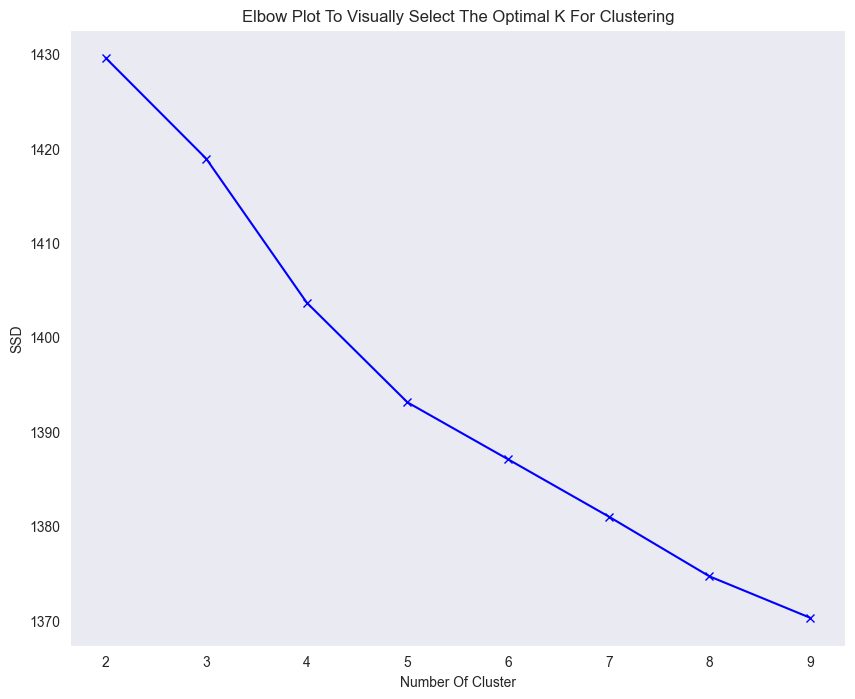

In [21]:
# Ploting an elbow plot (Num of clusters VS Sum of squared distances)
plt.figure(figsize=(10,8))
plt.title("Elbow Plot To Visually Select The Optimal K For Clustering")
plt.plot(range(2,10),SSD,'bx-')
plt.xlabel("Number Of Cluster")
plt.ylabel("SSD")
plt.show()

In [23]:
print("Total Explained Variance is ---> ",np.cumsum(svd.explained_variance_ratio_)[-1])

Total Explained Variance is --->  0.9999999999999989


Picking 5 as the  K plot 5 seems as the optimal number of clusters

In [22]:
# Initialize the model
kmeans = KMeans(n_clusters=5)

# Fit on the data
kmeans.fit(reduced_articles)

# Get the labels
labels = kmeans.labels_

Creating a dataframe of 

1. News Articles
2. Labels

To compare with the the ground truth

In [24]:
# Create a dictionary
df_dict = {"news":news_articles, 'labels_km':labels}

# Convert to dataframe 
df = pd.DataFrame(df_dict)

# Print head
df.head()

,news,labels_km
0,worldcom ex-boss launches defence lawyers defe...,0
1,german business confidence slides german busin...,0
2,bbc poll indicates economic gloom citizens in ...,0
3,lifestyle governs mobile choice faster bett...,3
4,enron bosses in $168m payout eighteen former e...,0


In [25]:
# Initlalize the tnse object
tsne = TSNE(n_components=2)

# Transform the data
tsne_data = tsne.fit_transform(reduced_articles)

# Convert to Dataframe
tsne_df = pd.DataFrame(tsne_data, columns=['comp1','comp2'])

In [26]:
def tsne_viz(tsne_df,labels,label_col='',ax=False):
    if not ax:
        plt.figure(figsize=(15,9))
        sns.scatterplot(x=tsne_df['comp1'],y=tsne_df['comp2'],hue=labels,palette='Set2')
        plt.show()
    else:
        ax.set_title(f"Visualising the clusters of {label_col} using TSNE")
        sns.scatterplot(x=tsne_df['comp1'],y=tsne_df['comp2'],hue=labels,palette='Set2',ax=ax)  

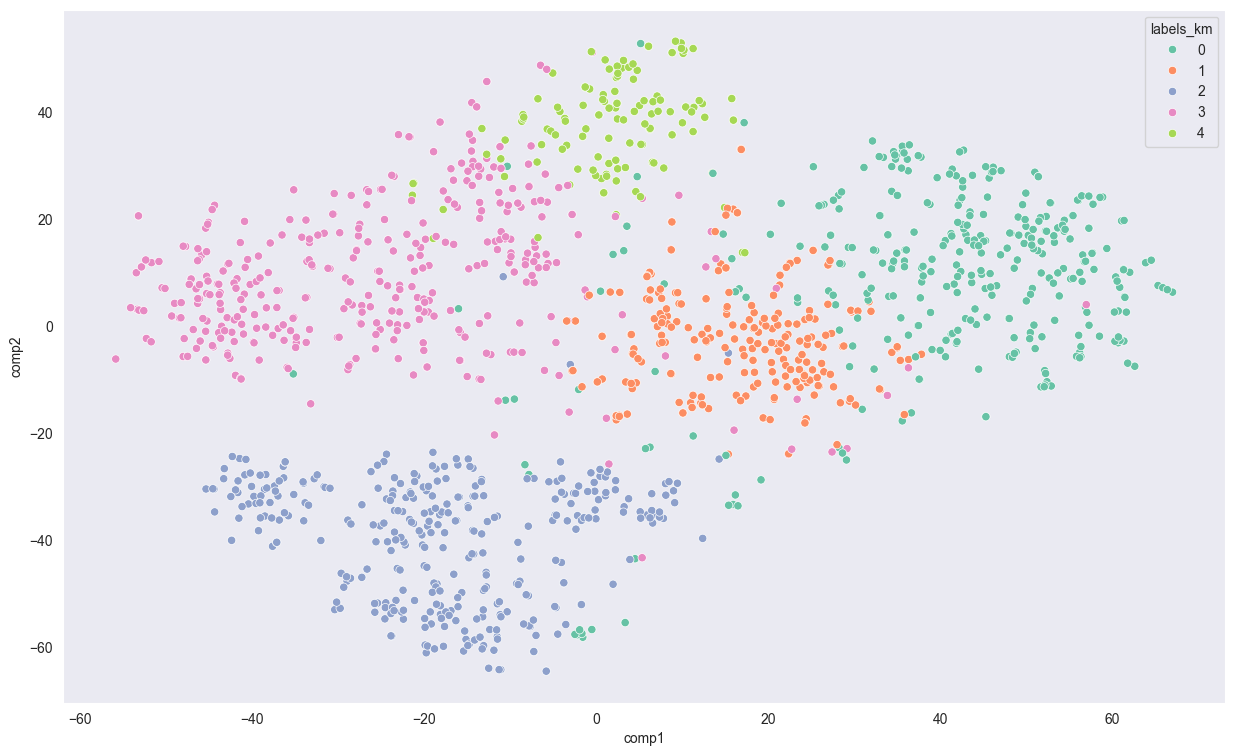

In [27]:
tsne_viz(tsne_df,df['labels_km'])